### Task 1

Mihkel Sildnik and Julio Ponte

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from statistics import mean

In [2]:
thedata = pd.read_csv('thedata.csv', skiprows=1)
thedata.head()
selected_columns = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
thedata = thedata[selected_columns].dropna()
thedata_shuffled = thedata.sample(frac=1.0, random_state=0)

In [3]:
def apply_label(num):
    return( ['None', 'Normal', 'Suspect', 'Pathologic'][int(num)] )

In [4]:
X = thedata_shuffled.drop('NSP', axis='columns')
Y = thedata_shuffled['NSP'].apply(apply_label)

In [5]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size=0.2,random_state=0)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


dtc = DecisionTreeClassifier(random_state=3)
# rfc = RandomForestClassifier()
# gbc = GradientBoostingClassifier()
# mlpc = MLPClassifier()
# knc = KNeighborsClassifier()

In [10]:
def try_classifiers(TrainingX,TrainingY):
    best_clf = None
    best_score = -1
    best_parameters = None
    scores=[]

    classifiers = [dtc,rfc,gbc,mlpc,knc]
    params = [{'max_depth':[x for x in range(3,20)]}#,
#               {'n_estimators':[100, 500, 1000, 1500, 2000]},
#               {'n_estimators':[500, 1000, 1500, 2000], 'learning_rate':[0.75, 0.1, 0.2]},
#               {'hidden_layer_sizes': [(100,20), (200,100)]},
#               {'n_neighbors':[3, 5, 7, 10]}
              ]
    
    for clf, params_to_test in zip(classifiers,params):  
        print("Testing estimators")
        clf_grid = GridSearchCV(estimator=clf, param_grid=params_to_test, verbose=0, cv=5)
        clf_grid.fit(TrainingX, TrainingY)
        scores.append(clf_grid.best_score_)
        if clf_grid.best_score_ > best_score : 
            best_clf = clf_grid.best_estimator_
            best_score = clf_grid.best_score_
            best_parameters = clf_grid.best_params_


    print('\n\n', 'best classifier: ', best_clf)
    print('best parameter and value: ', best_parameters)
    print('best score: ', best_score)

In [11]:
try_classifiers(Xtrain, Ytrain)

Testing estimators


 best classifier:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')
best parameter and value:  {'max_depth': 8}
best score:  0.9358823529411764


In [12]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=2000)
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
accuracy_score(Ytest,Yguess)

0.931924882629108

The best score was given by a Gradient Boosting Classifier with parameters and values: learning rate=0.1, number of estimators=2000

The best accuracy score of this classification algorithm when predicting the test data was 0.93192

### Task 2

In [13]:
class DecisionTreeLeaf:
    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        graph.node(node_id, str(self.value), style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

        
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id


In [14]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be 
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [15]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        XY = sorted(zip(X[:, feature], Y))

        n = len(XY)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = XY[i][0]
            y_i = XY[i][1]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = XY[i+1][0]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(XY[max_i][0] + XY[max_i+1][0])
        return score, feature, split_point

In [16]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

In [17]:
mean_scores=[]
for i in range (25):
    clf = TreeClassifier(max_depth=i)
    mean_scores.append(mean(cross_val_score(clf, Xtrain, Ytrain, cv=5)))
print(mean_scores.index(max(mean_scores)), max(mean_scores))

KeyboardInterrupt: 

In [18]:
clf = TreeClassifier(max_depth=19)
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
accuracy_score(Ytest, Yguess)

0.8802816901408451

The optimal depth found for the DecisionTree classifier is 19, giving an average training score of 0.8847, while its testing accuracy was: 0.8803

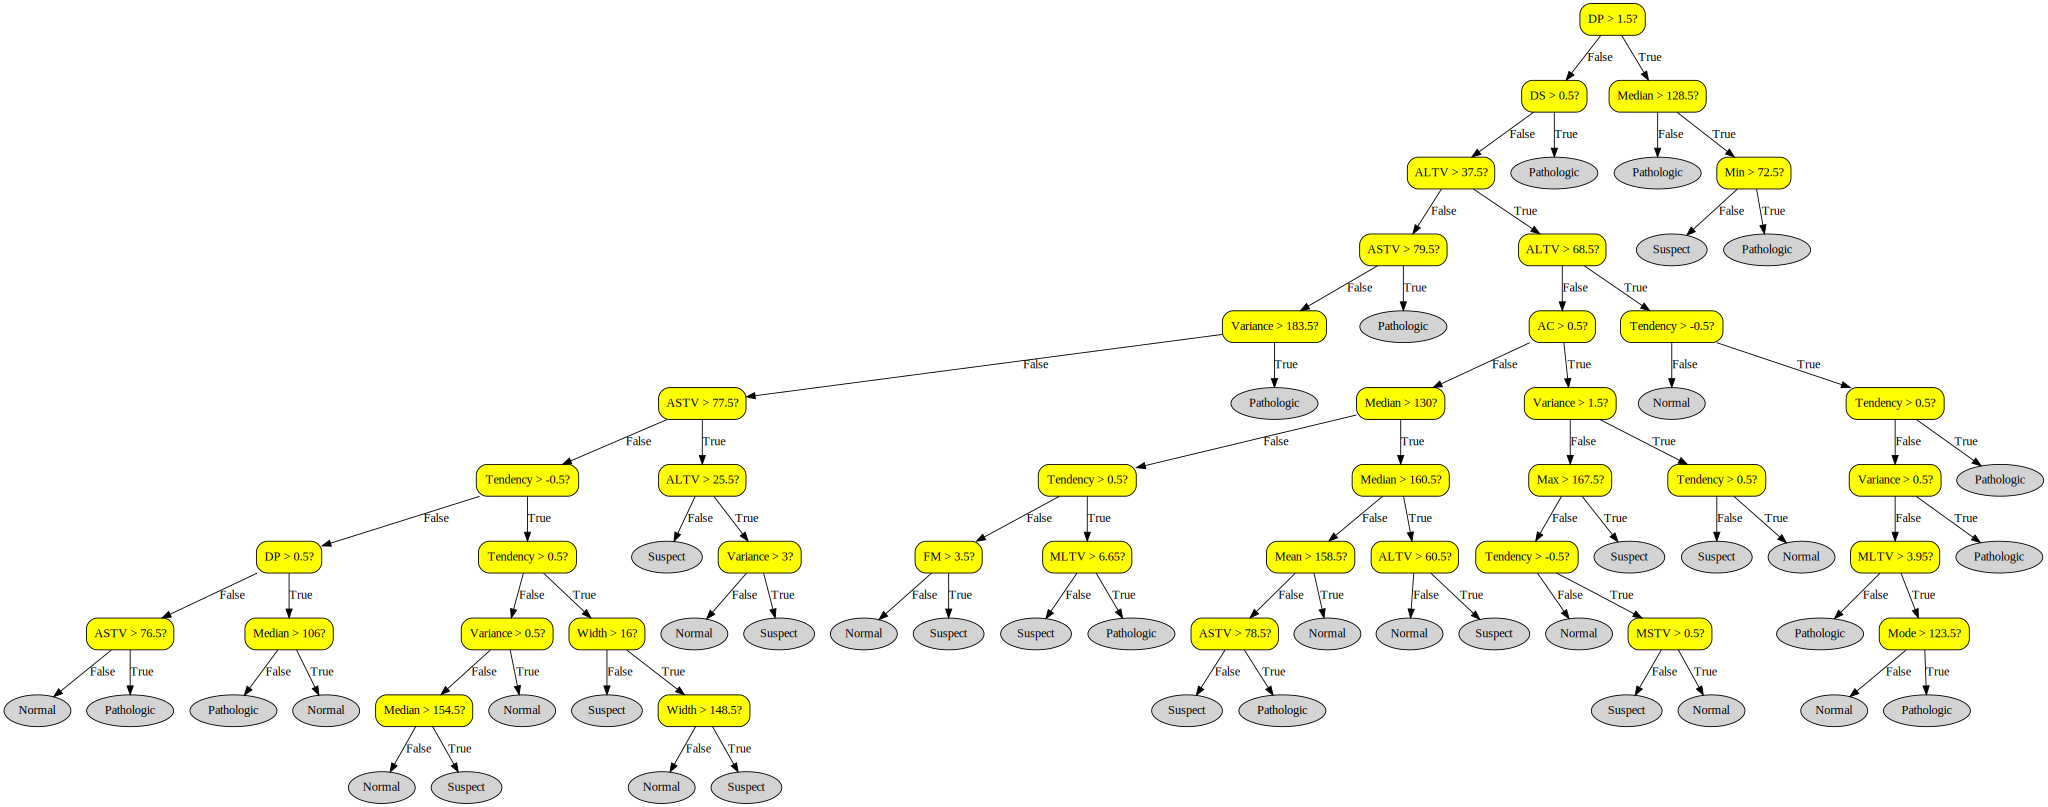

In [20]:
clf = TreeClassifier(max_depth=10)
clf.fit(Xtrain, Ytrain)
clf.draw_tree()

### Task 3

In [34]:
sberbank = pd.read_csv('sberbank.csv')

In [35]:
def get_year(timestamp):
    return int(timestamp[:4])

In [36]:
sberbank['year'] = sberbank['timestamp'].apply(get_year)
selected_cols = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
sberbank = sberbank[selected_cols]
sberbank = sberbank.dropna()
sberbank_shuffled = sberbank.sample(frac=1.0, random_state = 0)
X = sberbank_shuffled.drop('price_doc', axis='columns')
Y = sberbank_shuffled['price_doc'].apply(np.log)

In [37]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size = 0.2 , random_state=0)

In [38]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error

lr2 = LinearRegression()
r3 = Ridge() 
l4 = Lasso()
dt5 = DecisionTreeRegressor()
rf6 = RandomForestRegressor()
gb7 = GradientBoostingRegressor()
mlp8 = MLPRegressor()

In [39]:
def try_regressors(TrainingX,TrainingY):
    best_reg = None
    best_score = -1
    best_parameters = None
    scores=[]
    regressors = [lr2,r3,l4,dt5,rf6,gb7,mlp8]
    params = [{'normalize':[False]},
              {'alpha':[0.5, 1.0, 1.5, 2.5, 3.0]},
              {'alpha':[0.5, 1.0, 2.5, 4]},
              {'max_depth':[x for x in range(1,16,2)]},
              {'n_estimators':[100, 250, 500],'max_depth':[x for x in range(6,8)]},
              {'n_estimators':[100, 250, 500], 'learning_rate':[0.1, 0.8, 1.4]},
              {'hidden_layer_sizes': [(100,20), (200,100)]},
              ]
    
    for reg, params_to_test in zip(regressors,params):  
        print("Testing Regressor:", reg)
        reg_grid = GridSearchCV(estimator=reg, param_grid=params_to_test, verbose=0, cv=5, scoring='neg_mean_squared_error')
        reg_grid.fit(TrainingX, TrainingY)
        scores.append(reg_grid.best_score_)
        if reg_grid.best_score_ > best_score : 
            best_reg = reg_grid.best_estimator_
            best_score = reg_grid.best_score_
            best_parameters = reg_grid.best_params_


    print('\n\n', 'best regressor: ', best_reg)
    print('best parameter and value: ', best_parameters)
    print('best score: ', best_score)
    print('all scores: ', scores)

In [40]:
try_regressors(Xtrain,Ytrain)

Testing Regressor: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Testing Regressor: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Testing Regressor: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Testing Regressor: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
Testing Regressor: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
   

C:\Users\JulioPHX\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)




 best regressor:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
best parameter and value:  {'learning_rate': 0.1, 'n_estimators': 500}
best score:  -0.25459289336738766
all scores:  [-0.3013987201903755, -0.3013962740302152, -0.2993434538507586, -0.2826747055463879, -0.2689761242576762, -0.25459289336738766, -12713.58619172543]


In [46]:
reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500)
reg.fit(Xtrain, Ytrain)
Yguess = reg.predict(Xtest)
mean_squared_error(Ytest, Yguess)

0.2604748827888255

After trying out a variety of regressor models, we found that the best training score was achieved when using a Gradient boosting regressor, with parameters and values: learning rate=0.1 and number of estimators = 500

This results in a maximum training score (mean squared error) of -0.25459. And the accuracy when predicting the test data was 0.26047

### Task 4

In [78]:
from sklearn.base import RegressorMixin
class TreeRegressor(DecisionTree, RegressorMixin):
    def __init__(self, max_depth = 10, variance_threshold = 0):
        super().__init__(max_depth)
        self.variance_threshold = variance_threshold
    def fit(self, X, Y):
        # For decision tree regressors, we use variance reduction to measure
        # the homogeneity of subsets.
        # Declaring the size and variance of the whole set for use later
        self.var_whole = np.var(Y)
        self.whole_size = np.size(Y)

        super().fit(X, Y)
        
    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the mean.
    def get_default_value(self, Y):
        return np.mean(Y)
    
    # Checks whether a set of output values is homogeneous. In the regression case,
    # this means that the variance is under a threshold. We calculate the threshold as
    # a fraction of the largest value in the set
    def is_homogeneous(self, Y):
        return np.var(Y) <= self.variance_threshold * np.max(Y)
    
    def best_split(self, X, Y, feature):
        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        XY = sorted(zip(X[:, feature], Y))

        n = len(XY)

        # Size of the lower and higher part
        low_size = 0
        high_size = self.whole_size
        
        #Sums and sums of squares for the lower and higher parts
        low_sum = 0
        high_sum = np.sum(Y)
        low_sum_squares = 0
        high_sum_squares = np.sum(Y**2)
        
        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None
        
        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = XY[i][0]
            y_i = XY[i][1]

            # Update the sizes of the parts.
            low_size += 1
            high_size -= 1
            
            # Update the sums and sums of squares
            low_sum += y_i
            high_sum -= y_i
            low_sum_squares += y_i**2
            high_sum_squares -= y_i**2
            
            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = XY[i+1][0]
            if x_i == x_next:
                continue
                
            # Calculate the variances for the lower and higher parts
            variance_high = high_sum_squares / high_size - high_sum**2 / high_size**2
            variance_low = low_sum_squares / low_size - low_sum**2 / low_size**2
            
            # Compute the variance reduction score for a split at this position.
            score = self.var_whole - high_size / self.whole_size * variance_high - \
                    low_size / self.whole_size * variance_low

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(XY[max_i][0] + XY[max_i+1][0])
        return max_score, feature, split_point

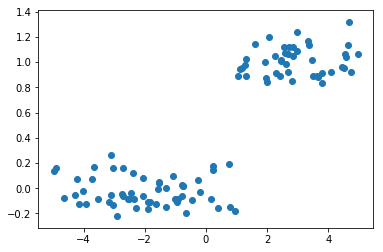

In [75]:
from matplotlib import pyplot 
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

X, Y = make_some_data(100)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
pyplot.scatter(X, Y) #The graph looks just as expected

Based on the function and scatter plot, it is obvious that we want a tree with depth 1, in other words a single split. We expect this split to be around the value of F0=1.

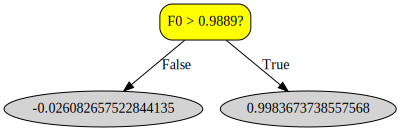

In [76]:
regressor = TreeRegressor(max_depth=1)
regressor.fit(Xtrain, Ytrain)
regressor.draw_tree()

As expected, the tree shows the split at around 1.

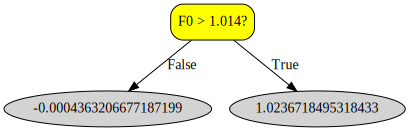

In [58]:
#Trying larger values of depth
regressor = TreeRegressor(max_depth=2)
regressor.fit(Xtrain, Ytrain)
Yguess = regressor.predict(Xtest)
regressor.draw_tree()

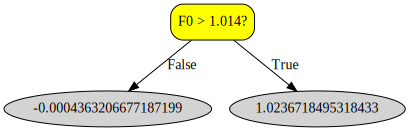

In [59]:
#Trying larger values of depth
regressor = TreeRegressor(max_depth=4)
regressor.fit(Xtrain, Ytrain)
Yguess = regressor.predict(Xtest)
regressor.draw_tree()

As we can see, even with greater values for the depth of the tree, no more splits are done because the data is homogeneous enough after the first split.

In [66]:
from sklearn.metrics import mean_squared_error as mse
tree_reg = TreeRegressor(max_depth=7)
X = sberbank_shuffled.drop('price_doc', axis=1)
Y = sberbank_shuffled['price_doc'].apply(np.log)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
tree_reg.fit(Xtrain, Ytrain)
Ypredict = tree_reg.predict(Xtest)
score = mse(Ytest, Ypredict) #0.34

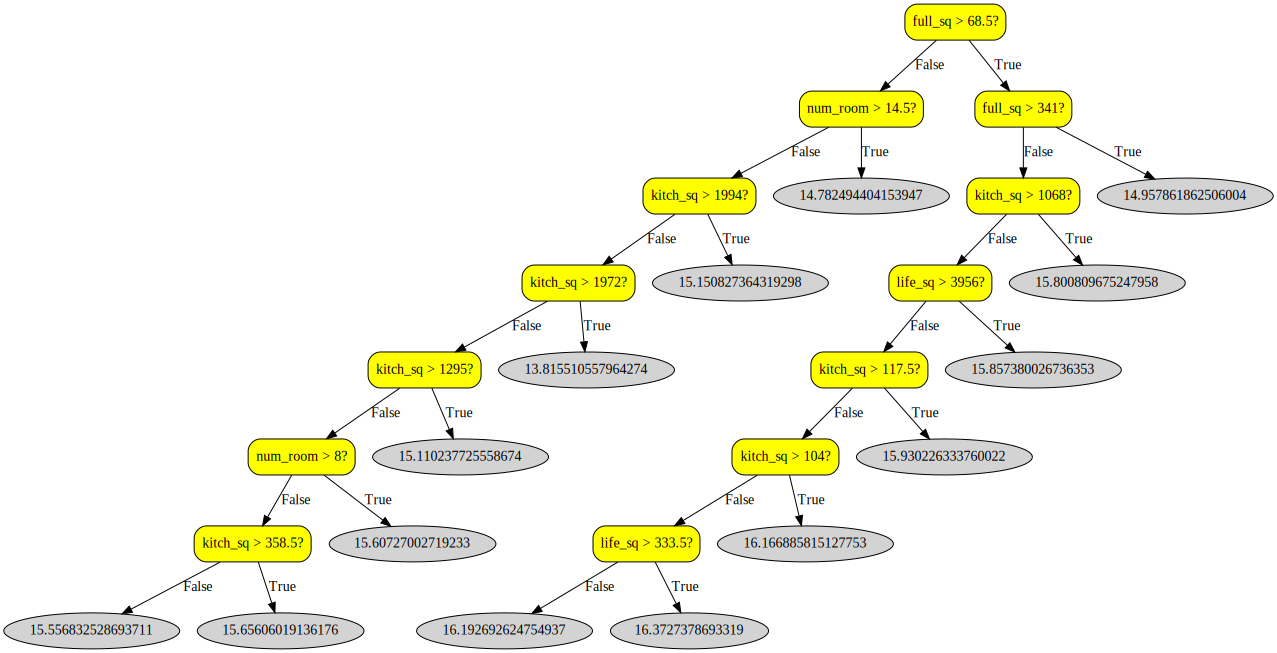

In [61]:
tree_reg.draw_tree()

We used a depth of 7 and got a mean squared error of 0.34, which is consistent with the regressors that we tried in task 3.

In [77]:
training_scores = []
test_scores = []
for depth in range(13):
    tree_reg = TreeRegressor(max_depth=depth, variance_threshold=1e-9)
    tree_reg.fit(Xtrain, Ytrain)
    Ypredict_test = tree_reg.predict(Xtest)
    Ypredict_train = tree_reg.predict(Xtrain)
    training_scores.append(mse(Ytrain, Ypredict_train))
    test_scores.append(mse(Ytest, Ypredict_test))

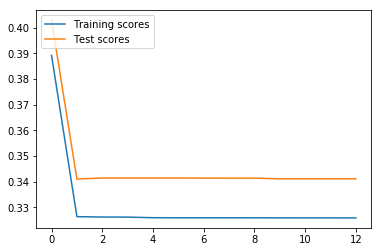

In [72]:
x_axis = [x for x in range(30)]
pyplot.plot(x_axis, training_scores)
pyplot.plot(x_axis, test_scores)
pyplot.legend(['Training scores', 'Test scores'], loc = 'upper left')
pyplot.show()

From the graph we conclude that there is a trivial issue in our code above because overfitting is not happening nearly as fast as expected even for large values for the depth. At least, the error for the test set is larger than that of the training set as expected.
We tried a larger range of depth values because overfitting did not seem to be happening at all.

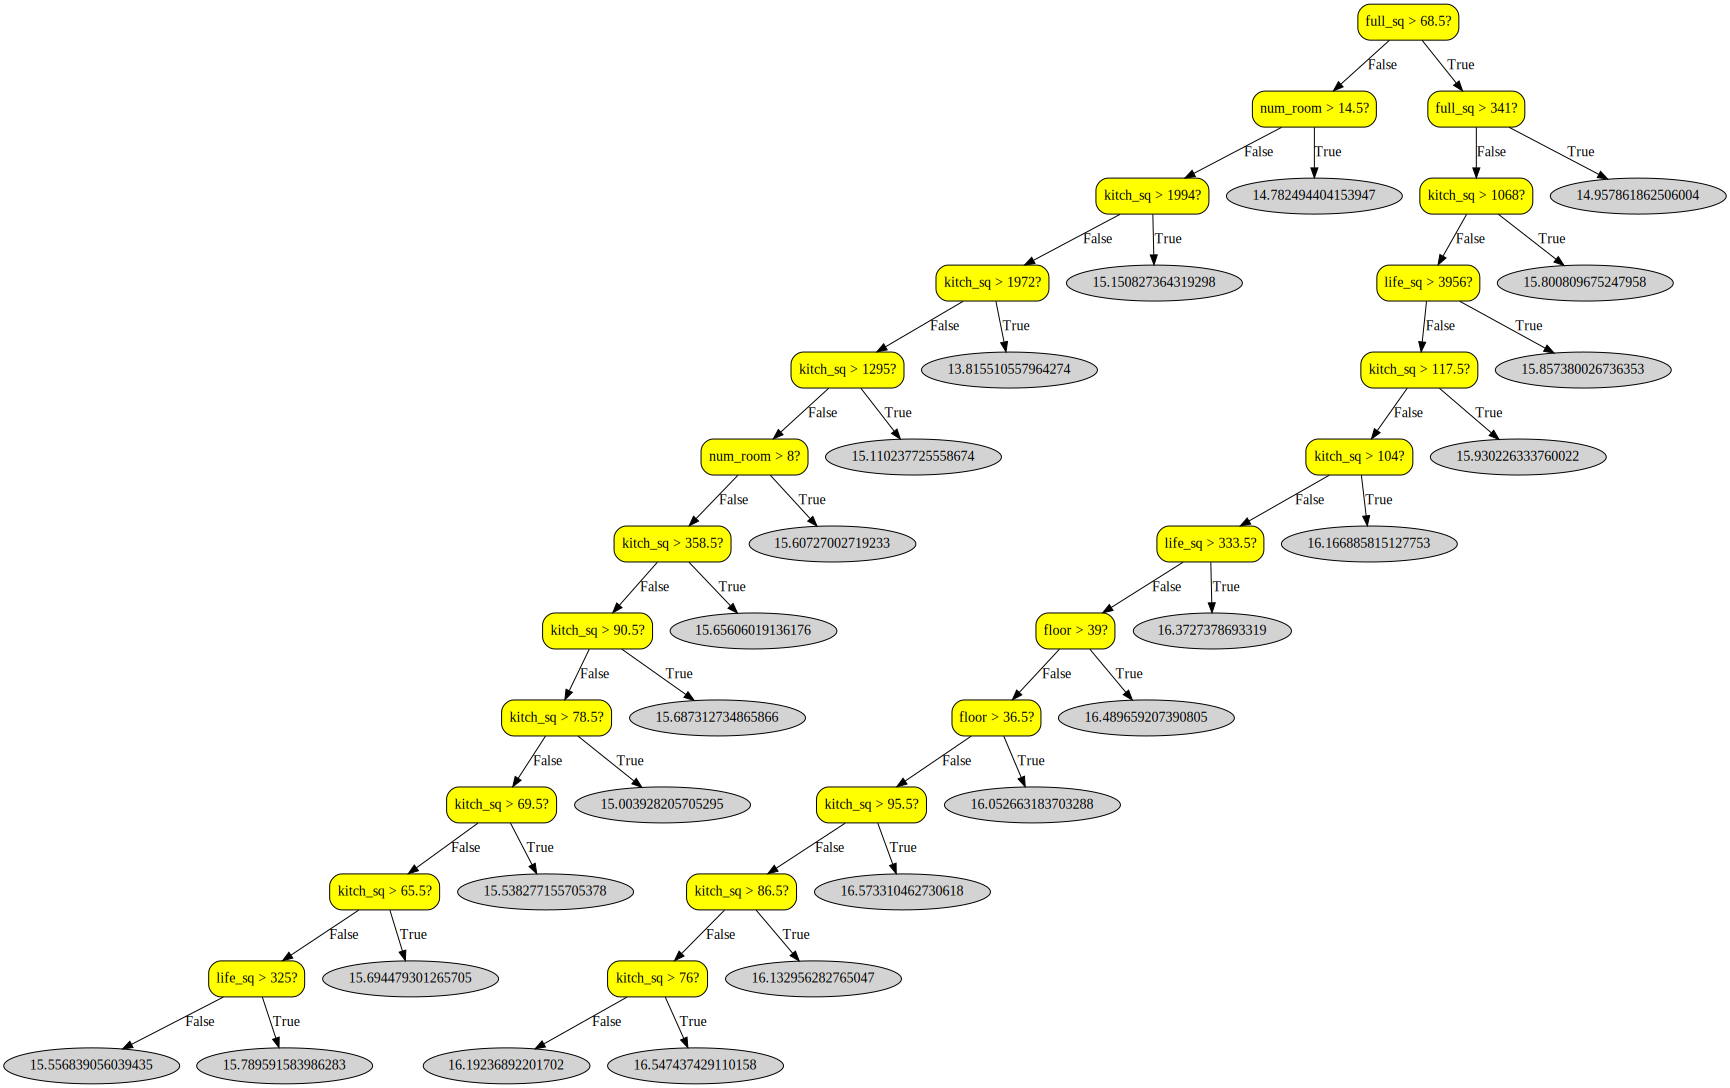

In [64]:
tree_reg.draw_tree()


